# Modeling

This notebook compares multiple machine learning models for a binary classification task, starting from a selected feature set.

It manually splits the data into training, testing, and out-of-time (OOT) periods, and evaluates each model by running multiple randomized splits to get stable detection rate (FDR) estimates.

Models include logistic regression, decision trees, random forests, boosting methods, neural networks, SVM, and KNN.

The best model is retrained on the full training data, and business performance tables are created to estimate fraud savings and false positive costs.
Finally, overfitting behavior is checked by varying model complexity and monitoring performance across datasets.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [152]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [153]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 96.9 ms, sys: 21.5 ms, total: 118 ms
Wall time: 124 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,...,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since,Recnum,Fraud
0,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,3.62,3.62,...,3.62,0.000098,1,1,1,1,1461.0,1461.0,1,0
1,1,31.42,0.000049,0.000278,1,31.42,0.000278,0.000049,31.42,31.42,...,31.42,0.000098,1,1,1,1,1461.0,1461.0,2,0
2,1,178.49,0.000049,0.000278,1,178.49,0.000278,0.000049,178.49,178.49,...,178.49,0.000098,1,1,1,1,1461.0,1461.0,3,0
3,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,3.62,3.62,...,3.62,0.000098,1,1,1,1,1461.0,1461.0,4,0
4,1,7.24,0.071429,0.000278,1,7.24,0.000278,0.071429,3.62,7.24,...,7.24,0.142857,1,1,1,1,0.0,0.0,5,0


In [154]:
# set the number of variables desired here, and set the names of the y and record number properly

# Chose nvars to be 15 finally since most models achieved a reasonably good performance using nvars = 15
NVARS = 20

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_total_7',
 'card_merch_vdratio_0by14',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_Card_Merchdesc_1',
 'state_des_total_3',
 'card_zip_count_1_by_60_sq',
 'Card_dow_vdratio_0by14',
 'Cardnum_max_14',
 'Card_Merchdesc_total_30',
 'card_state_total_14',
 'Card_Merchdesc_avg_7',
 'Cardnum_total_14',
 'Card_dow_vdratio_0by7',
 'Card_dow_unique_count_for_state_des_1',
 'Cardnum_unique_count_for_card_state_7',
 'Cardnum_unique_count_for_card_zip_7',
 'Cardnum_unique_count_for_Merchnum_7',
 'Cardnum_day_since',
 'Card_dow_day_since']

In [155]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,...,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
0,1,0,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,...,3.62,3.62,3.62,0.000098,1,1,1,1,1461.0,1461.0
1,2,0,1,31.42,0.000049,0.000278,1,31.42,0.000278,0.000049,...,31.42,31.42,31.42,0.000098,1,1,1,1,1461.0,1461.0
2,3,0,1,178.49,0.000049,0.000278,1,178.49,0.000278,0.000049,...,178.49,178.49,178.49,0.000098,1,1,1,1,1461.0,1461.0
3,4,0,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,...,3.62,3.62,3.62,0.000098,1,1,1,1,1461.0,1461.0
4,5,0,1,7.24,0.071429,0.000278,1,7.24,0.000278,0.071429,...,7.24,3.62,7.24,0.142857,1,1,1,1,0.0,0.0


In [156]:
vars.shape

(97496, 22)

In [157]:
vars['Fraud'].sum()

2047

In [158]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [159]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,...,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
0,1,0,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,...,3.62,3.62,3.62,0.000098,1,1,1,1,1461.0,1461.0
1,2,0,1,31.42,0.000049,0.000278,1,31.42,0.000278,0.000049,...,31.42,31.42,31.42,0.000098,1,1,1,1,1461.0,1461.0
2,3,0,1,178.49,0.000049,0.000278,1,178.49,0.000278,0.000049,...,178.49,178.49,178.49,0.000098,1,1,1,1,1461.0,1461.0
3,4,0,1,3.62,0.000049,0.000278,1,3.62,0.000278,0.000049,...,3.62,3.62,3.62,0.000098,1,1,1,1,1461.0,1461.0
4,5,0,1,7.24,0.071429,0.000278,1,7.24,0.000278,0.071429,...,7.24,3.62,7.24,0.142857,1,1,1,1,0.0,0.0
5,6,0,1,3.67,0.000049,0.000278,1,3.67,0.000278,0.000049,...,3.67,3.67,3.67,0.000098,1,1,1,1,1461.0,1461.0
6,7,0,1,3.62,0.000049,0.000278,1,7.24,0.000278,0.000049,...,3.62,3.62,3.62,0.000098,1,1,1,1,1461.0,1461.0
7,8,0,1,230.32,0.000049,0.000278,1,230.32,0.000278,0.000049,...,230.32,230.32,230.32,0.000098,1,1,1,1,1461.0,1461.0
8,9,0,1,62.11,0.000049,0.000278,1,62.11,0.000278,0.000049,...,62.11,62.11,62.11,0.000098,1,1,1,1,1461.0,1461.0
9,10,0,1,10.86,0.071429,0.000278,1,10.86,0.000278,0.071429,...,10.86,3.62,10.86,0.142857,1,1,1,1,0.0,0.0


In [160]:
vars.shape

(97496, 22)

In [161]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,...,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,9.749600e+04,97496.000000,97496.000000,9.749600e+04,97496.000000,...,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.717953,0.009267,4.165378e-05,1.571193,1499.699665,1.837458e-04,0.020482,...,1146.593013,397.752225,3882.262430,0.047073,1.571264,3.010595,3.793571,3.959301,29.979527,163.133954
std,28262.212670,0.143371,1.568565,4074.945381,0.019766,5.656029e-05,1.882741,5319.179574,1.017907e-04,0.026914,...,4493.692015,785.969013,10014.446029,0.058449,1.882744,2.492444,3.869054,4.025994,194.913342,451.126110
min,1.000000,0.000000,1.000000,0.010000,0.000039,5.050505e-07,1.000000,0.010000,5.078204e-07,0.000039,...,0.010000,0.010000,0.140000,0.000078,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,24428.750000,0.000000,1.000000,52.500000,0.000045,1.068376e-05,1.000000,103.867500,9.259259e-05,0.001587,...,113.557500,38.983750,566.245000,0.003968,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000
50%,48916.000000,0.000000,1.000000,189.000000,0.001066,2.136752e-05,1.000000,371.990000,2.777778e-04,0.002976,...,365.575000,150.865000,1758.980000,0.008929,1.000000,2.000000,3.000000,3.000000,1.000000,7.000000
75%,73402.250000,0.000000,2.000000,590.000000,0.004464,4.629630e-05,2.000000,1384.942500,2.777778e-04,0.042857,...,1086.647500,445.511667,4193.187500,0.107143,2.000000,4.000000,5.000000,5.000000,5.000000,28.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.071429,2.777778e-04,38.000000,307302.580000,2.777778e-04,0.071429,...,306633.410000,28392.840000,313995.060000,0.142857,38.000000,25.000000,50.000000,52.000000,1817.000000,1825.000000


In [162]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,...,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
84935,85265,0,1,174.61,0.002747,0.000139,1,174.61,0.000139,0.000317,...,399.61,174.61,399.61,0.000635,1,1,1,1,12.0,224.0
84936,85266,0,1,53.00,0.002041,0.000010,1,53.00,0.000025,0.001190,...,421.25,53.00,988.23,0.009524,1,2,3,3,3.0,14.0
84937,85267,0,1,25.00,0.003968,0.000019,1,25.00,0.000093,0.002976,...,557.50,25.00,597.15,0.008929,1,2,2,2,7.0,7.0
84938,85268,0,1,97.17,0.000040,0.000019,1,97.17,0.000278,0.001661,...,97.17,97.17,794.18,0.003322,1,1,1,1,10.0,42.0
84939,85269,0,1,6.51,0.002747,0.000093,1,6.51,0.000093,0.001429,...,6.51,6.51,6.51,0.002857,1,1,1,1,25.0,49.0
84940,85270,0,1,170.00,0.000040,0.000046,1,170.00,0.000278,0.001116,...,170.00,170.00,170.00,0.002232,1,1,1,1,20.0,63.0
84941,85271,0,1,250.00,0.000455,0.000008,1,250.00,0.000278,0.001786,...,472.58,250.00,655.58,0.008929,1,2,3,3,3.0,7.0
84942,85272,0,1,15.00,0.000040,0.000019,1,15.00,0.000278,0.001429,...,15.00,15.00,118.60,0.002857,1,2,2,2,3.0,49.0
84943,85273,0,1,300.00,0.001832,0.000006,1,300.00,0.000035,0.001984,...,4395.00,300.00,4395.00,0.003968,1,1,3,3,4.0,35.0
84944,85274,0,1,133.20,0.008929,0.000017,1,133.20,0.000046,0.004464,...,133.20,66.60,497.20,0.008929,1,3,3,3,3.0,7.0


In [163]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [164]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
count,97496.000000,97496.000000,97496.000000,9.749600e+04,97496.000000,97496.000000,9.749600e+04,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.717953,0.009267,4.165378e-05,1.571193,1499.699665,1.837458e-04,0.020482,1194.385741,901.136228,1146.593013,397.752225,3882.262430,0.047073,1.571264,3.010595,3.793571,3.959301,29.979527,163.133954
std,1.568565,4074.945381,0.019766,5.656029e-05,1.882741,5319.179574,1.017907e-04,0.026914,1856.894526,4290.972743,4493.692015,785.969013,10014.446029,0.058449,1.882744,2.492444,3.869054,4.025994,194.913342,451.126110
min,1.000000,0.010000,0.000039,5.050505e-07,1.000000,0.010000,5.078204e-07,0.000039,0.140000,0.010000,0.010000,0.010000,0.140000,0.000078,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,52.500000,0.000045,1.068376e-05,1.000000,103.867500,9.259259e-05,0.001587,307.000000,63.810000,113.557500,38.983750,566.245000,0.003968,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000
50%,1.000000,189.000000,0.001066,2.136752e-05,1.000000,371.990000,2.777778e-04,0.002976,801.660000,246.645000,365.575000,150.865000,1758.980000,0.008929,1.000000,2.000000,3.000000,3.000000,1.000000,7.000000
75%,2.000000,590.000000,0.004464,4.629630e-05,2.000000,1384.942500,2.777778e-04,0.042857,1743.000000,795.000000,1086.647500,445.511667,4193.187500,0.107143,2.000000,4.000000,5.000000,5.000000,5.000000,28.000000
max,21.000000,306633.410000,0.071429,2.777778e-04,38.000000,307302.580000,2.777778e-04,0.071429,47900.000000,306633.410000,306633.410000,28392.840000,313995.060000,0.142857,38.000000,25.000000,50.000000,52.000000,1817.000000,1825.000000


In [165]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [166]:
# cap variables
Clip = 10

In [167]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,-3.469048e-17,-5.538817e-18,-1.763676e-17,-1.166067e-17,-3.323290e-17,-2.332133e-18,-2.332133e-17,3.410745e-17,1.836555e-17,-1.515887e-17,-2.769408e-18,1.340977e-17,6.413367e-18,6.996400e-18,-2.448740e-17,-5.830333e-18,-6.996400e-18,1.574190e-17,1.749100e-17,2.565347e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346955e-01,-4.668316e-01,-7.275198e-01,-3.208247e-01,-4.186887e-01,-1.800145e+00,-7.595529e-01,-7.194261e-01,-3.657128e-01,-4.151520e-01,-5.833064e-01,-4.908157e-01,-8.040309e-01,-3.208649e-01,-8.066762e-01,-7.244329e-01,-7.374301e-01,-1.538095e-01,-3.616150e-01
25%,-4.651796e-01,-3.066096e-01,-4.665191e-01,-5.475577e-01,-3.208247e-01,-3.884459e-01,-8.954968e-01,-7.020303e-01,-5.318162e-01,-3.382999e-01,-3.720913e-01,-5.252640e-01,-4.165648e-01,-7.374772e-01,-3.208649e-01,-8.066762e-01,-7.244329e-01,-4.881201e-01,-1.538095e-01,-3.616150e-01
50%,-4.651796e-01,-2.335723e-01,-4.148746e-01,-3.586661e-01,-3.208247e-01,-3.103697e-01,9.237778e-01,-6.504263e-01,-2.293881e-01,-2.597415e-01,-2.765183e-01,-3.586426e-01,-2.601246e-01,-6.526120e-01,-3.208649e-01,-4.054636e-01,-2.055283e-01,-2.388101e-01,-1.486790e-01,-3.460982e-01
75%,1.782986e-01,-1.900840e-02,-2.429535e-01,8.208080e-02,2.516598e-01,-1.540228e-02,9.237778e-01,8.313456e-01,3.461339e-01,-2.413067e-02,-3.064948e-03,8.016560e-02,5.914839e-02,1.027719e+00,2.516177e-01,3.969616e-01,3.133764e-01,2.598099e-01,-1.281571e-01,-2.995481e-01
max,1.009425e+01,2.183128e+01,3.144902e+00,4.174731e+00,1.078457e+01,1.550724e+01,9.237778e-01,1.892914e+00,1.136351e+01,1.845843e+01,1.706116e+01,1.171423e+01,1.315341e+01,1.638749e+00,1.078456e+01,8.822426e+00,1.003872e+01,1.003756e+01,9.168282e+00,3.683817e+00


In [168]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [169]:
X_trntst_save = X_trntst.copy()

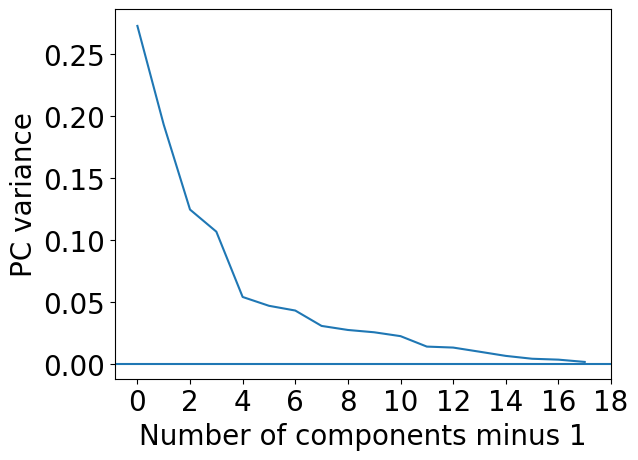

In [170]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [171]:
# look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-3.336449,0.349479,-1.824846,7.442163
1,-3.314614,0.382577,-1.826317,7.446684
2,-3.199099,0.557676,-1.834098,7.470600
3,-3.336449,0.349479,-1.824846,7.442163
4,-1.082938,-0.962445,-4.721959,0.538017


In [172]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,0.516115,-1.079340,0.889935,0.064459
85265,-0.679959,-1.065972,-2.031249,-0.625330
85266,-0.425608,2.558536,-0.136080,0.889265
85267,-0.985200,0.130285,0.938772,-0.073383
85268,-1.201531,0.548281,0.688555,-0.093786


In [173]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002805,-0.000710,0.000201,0.010628,0.012239,-0.016298,0.003494,0.003866,0.003127,0.001488,0.004173,0.006116,0.004760,0.010634,0.006369,0.006114,0.005994,0.014972,0.025314
std,1.007299,1.029151,0.995514,1.014526,1.030808,1.042071,1.008192,1.000623,0.988241,1.022946,1.014499,1.015393,1.021940,1.000962,1.030808,1.009276,1.007560,1.007086,1.057443,1.034338
min,-0.465180,-0.334696,-0.466765,-0.727520,-0.320825,-0.418689,-1.800145,-0.759504,-0.719426,-0.365713,-0.415152,-0.583306,-0.490816,-0.803986,-0.320865,-0.806676,-0.724433,-0.737430,-0.153810,-0.361615
25%,-0.465180,-0.307467,-0.466506,-0.554554,-0.320825,-0.388608,-0.895497,-0.699287,-0.528478,-0.339335,-0.372182,-0.528293,-0.415569,-0.737477,-0.320865,-0.806676,-0.464981,-0.488120,-0.153810,-0.361615
50%,-0.465180,-0.234966,-0.412346,-0.358666,-0.320825,-0.310949,0.675695,-0.640374,-0.220376,-0.261022,-0.276234,-0.358561,-0.256957,-0.652612,-0.320865,-0.405464,-0.205528,-0.238810,-0.148679,-0.346098
75%,0.178299,-0.019273,-0.242954,0.082081,0.251660,-0.011548,0.923778,0.831346,0.354082,-0.024560,-0.002742,0.083911,0.066025,1.027719,0.251618,0.396962,0.313376,0.259810,-0.128157,-0.299548
max,10.094246,21.831284,3.144902,4.174731,10.784575,15.507239,0.923778,1.892914,11.363510,18.458429,17.061161,11.714235,13.153409,1.638749,10.784555,8.822426,10.038717,10.037560,8.886105,3.553033


In [174]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.133055,-0.007576,0.033951,-0.148319
std,2.089835,1.623563,1.493759,0.970907
min,-3.570931,-12.117528,-7.984551,-2.542740
25%,-1.464693,-0.617935,-0.686771,-0.687818
50%,-0.619095,-0.009501,0.416144,-0.186585
75%,0.528700,0.428527,0.878153,0.150638
max,22.124887,32.422765,8.340668,9.182327


In [175]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [176]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,2.133362e-17,4.000053e-18,2.400032e-17,4.000053e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.487374e+00,-6.679346e+00,-6.093393e+00,-1.776236e+00
25%,-5.912080e-01,-3.565852e-01,-5.405434e-01,-5.272418e-01
50%,-2.163343e-01,-1.338614e-02,2.624524e-01,-1.460630e-01
75%,2.940904e-01,2.384081e-01,5.727947e-01,1.390324e-01
max,1.186406e+01,1.762138e+01,6.782708e+00,6.588617e+00


In [177]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.056025,-0.003791,0.021153,-0.099835
std,0.879962,0.812457,0.930713,0.653526
min,-1.503604,-6.063803,-4.974917,-1.711539
25%,-0.616735,-0.309224,-0.427905,-0.462976
50%,-0.260681,-0.004755,0.259286,-0.125592
75%,0.222618,0.214442,0.547149,0.101396
max,9.316075,16.224866,5.196803,6.180698


In [178]:
X_trntst_pca.shape

(85264, 4)

In [179]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [180]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that we want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled_before = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled_before.shape,len(Y_trntst_sampled))



0.020524488647025708
(3464, 20) 3464


In [181]:
X_trntst_sampled_before

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,card_state_total_14,Card_Merchdesc_avg_7,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since
1,-0.465180,-0.317889,-0.466339,4.174731,-0.320825,-0.409542,0.923778,-0.759191,-0.700302,-0.352217,-0.403240,-0.536528,-0.486713,-0.803698,-0.320865,-0.806676,-0.724433,-0.73743,7.341829,2.876947
2,-0.465180,-0.239196,-0.466339,4.174731,-0.320825,-0.366716,0.923778,-0.759191,-0.610385,-0.289026,-0.347467,-0.317502,-0.467423,-0.803698,-0.320865,-0.806676,-0.724433,-0.73743,7.341829,2.876947
31,-0.465180,-0.064704,-0.466339,4.174731,-0.320825,-0.271754,0.923778,-0.759191,-0.411006,-0.148906,-0.223796,0.168164,-0.424650,-0.803698,-0.320865,-0.806676,-0.724433,-0.73743,7.341829,2.876947
37,0.178299,-0.319708,-0.466339,4.174731,0.824144,-0.410532,0.923778,1.892914,-0.702381,-0.353678,-0.404530,-0.541592,-0.482879,1.638749,0.824100,-0.405464,-0.464981,-0.48812,-0.153810,-0.361615
51,0.821777,-0.274837,-0.466339,4.174731,1.396629,-0.386113,0.923778,1.892914,-0.651110,-0.317646,-0.372727,-0.416702,-0.467255,1.638749,1.396583,-0.004251,-0.205528,-0.23881,-0.153810,-0.361615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84941,-0.465180,-0.200933,-0.445793,-0.587626,-0.320825,-0.345893,0.923778,-0.694658,-0.566665,-0.258300,-0.235939,-0.211004,-0.404848,-0.652612,-0.320865,-0.405464,-0.205528,-0.23881,-0.138418,-0.346098
84969,-0.465180,-0.291895,-0.466764,-0.289978,-0.320825,-0.395396,-0.440678,-0.687286,-0.400368,-0.331344,-0.324140,-0.464180,-0.390889,-0.737477,-0.320865,-0.405464,-0.464981,-0.23881,-0.138418,-0.284031
85139,-0.465180,-0.093020,-0.452750,1.719141,-0.320825,-0.287164,0.923778,-0.745927,-0.443361,-0.171644,-0.243865,0.089352,-0.431591,-0.791482,-0.320865,-0.806676,-0.724433,-0.73743,0.056540,0.026303
85239,-0.465180,-0.315224,-0.466765,-0.567098,-0.320825,-0.408092,0.923778,-0.672542,-0.600903,-0.350077,-0.401352,-0.529112,-0.441918,-0.642428,-0.320865,-0.405464,-0.464981,-0.48812,-0.123027,-0.330582


In [182]:
Y_trntst_sampled.sum()

Fraud    1750
dtype: int64

In [183]:
niter = 0
nitermax = 5
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

In [184]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [185]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='l2', C=0.5 , solver='lbfgs', l1_ratio = None)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6869918699186992 0.6961538461538461 0.494949494949495
1 0.6988448844884488 0.6747211895910781 0.5016835016835017
2 0.6876019575856444 0.6965648854961832 0.494949494949495
3 0.704248366013072 0.6749049429657795 0.494949494949495
4 0.6988543371522095 0.6875 0.4983164983164983
trn    0.695308
tst    0.685969
oot    0.496970
dtype: float64
CPU times: user 9.88 s, sys: 1.34 s, total: 11.2 s
Wall time: 1.58 s


In [186]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(
    criterion='gini',      # Measure quality of split with Gini impurity
    splitter='best',       # Use the best split as the strategy
    max_depth=20,        # No maximum depth, expand nodes until leaves are pure
    min_samples_split=200,   # Minimum of 2 samples required to split a node
    min_samples_leaf=100     # Minimum of 1 sample required to be at a leaf node
)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7625 0.72 0.569023569023569
1 0.7832792207792207 0.7316602316602316 0.531986531986532
2 0.765089722675367 0.7137404580152672 0.6161616161616161
3 0.7621000820344545 0.7231638418079096 0.5555555555555556
4 0.7630922693266833 0.7330895795246801 0.5252525252525253
trn    0.767212
tst    0.724331
oot    0.559596
dtype: float64
CPU times: user 5.08 s, sys: 763 ms, total: 5.84 s
Wall time: 4.6 s


In [187]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(
    n_estimators = 100,    # Number of trees
    criterion = 'gini',    # Criterion for splitting nodes (gini or entropy)
    max_depth = None,      # Maximum depth of each tree
    min_samples_split = 2, # Minimum number of samples required to split an internal node
    min_samples_leaf = 1   # Minimum number of samples required to be at a leaf node
)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 1.0 0.8453038674033149 0.6430976430976431
1 1.0 0.8657844990548205 0.6464646464646465
2 1.0 0.8782771535580525 0.632996632996633
3 1.0 0.8802281368821293 0.6599326599326599
4 1.0 0.8611632270168855 0.6565656565656566
trn    1.000000
tst    0.866151
oot    0.647811
dtype: float64
CPU times: user 1min 2s, sys: 170 ms, total: 1min 2s
Wall time: 1min 3s


In [188]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
    num_leaves = 30,
    max_depth = -1, 
    learning_rate = 0.1,     # learning rate
    n_estimators = 200       # Number of boosting rounds
)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1212, number of negative: 58472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3693
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020307 -> initscore=-3.876276
[LightGBM] [Info] Start training from score -3.876276
0 1.0 0.8605947955390335 0.6094276094276094
[LightGBM] [Info] Number of positive: 1250, number of negative: 58434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3702
[LightGBM] [Info] Number of data points in the train set: 59684, numb

In [189]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = MLPClassifier(
    hidden_layer_sizes=(100, 1),  
    activation='relu',             # Rectified Linear Unit activation function
    alpha = 0.0001,                  # L2 penalty (regularization term)
    learning_rate_init = 0.0001,      # Initial learning rate for weight updates
    max_iter = 500,                 # Maximum number of iterations
    learning_rate='constant'       # Learning rate schedule
)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6118577075098814 0.5876288659793815 0.5117845117845118
1 0.5366639806607575 0.5442043222003929 0.6161616161616161
2 0.819000819000819 0.7996219281663516 0.632996632996633
3 0.8244897959183674 0.7942857142857143 0.6296296296296297
4 0.813973063973064 0.7953736654804271 0.6161616161616161
trn    0.721197
tst    0.704223
oot    0.601347
dtype: float64
CPU times: user 12min 15s, sys: 31.3 s, total: 12min 46s
Wall time: 1min 39s


## Model comparison plots

In [190]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.686992,0.696154,0.494949
1,log reg,0.698845,0.674721,0.501684
2,log reg,0.687602,0.696565,0.494949
3,log reg,0.704248,0.674905,0.494949
4,log reg,0.698854,0.6875,0.498316
5,DT,0.7625,0.72,0.569024
6,DT,0.783279,0.73166,0.531987
7,DT,0.76509,0.71374,0.616162
8,DT,0.7621,0.723164,0.555556
9,DT,0.763092,0.73309,0.525253


In [191]:
df.shape

(25, 4)

In [192]:
df_unpivot = df.melt(id_vars='Model', value_vars=['Trn', 'Tst', 'OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.686992
1,log reg,Trn,0.698845
2,log reg,Trn,0.687602
3,log reg,Trn,0.704248
4,log reg,Trn,0.698854


In [193]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.686992
1,log reg,Trn,0.698845
2,log reg,Trn,0.687602
3,log reg,Trn,0.704248
4,log reg,Trn,0.698854


In [194]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.767212  0.009055  0.724331  0.008104  0.559596  0.036217
LGBM          1.0  0.000000   0.87549  0.013852  0.620202  0.041470
NN       0.721197  0.136794  0.704223  0.127201  0.601347  0.050651
RF            1.0  0.000000  0.866151  0.014185  0.647811  0.010806
log reg  0.695308  0.007641  0.685969  0.010808   0.49697  0.003012

In [195]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.686992,0.696154,0.494949
1,log reg,0.698845,0.674721,0.501684
2,log reg,0.687602,0.696565,0.494949
3,log reg,0.704248,0.674905,0.494949
4,log reg,0.698854,0.6875,0.498316


In [196]:
best_OOT = df['OOT'].max()
best_OOT

0.6632996632996633

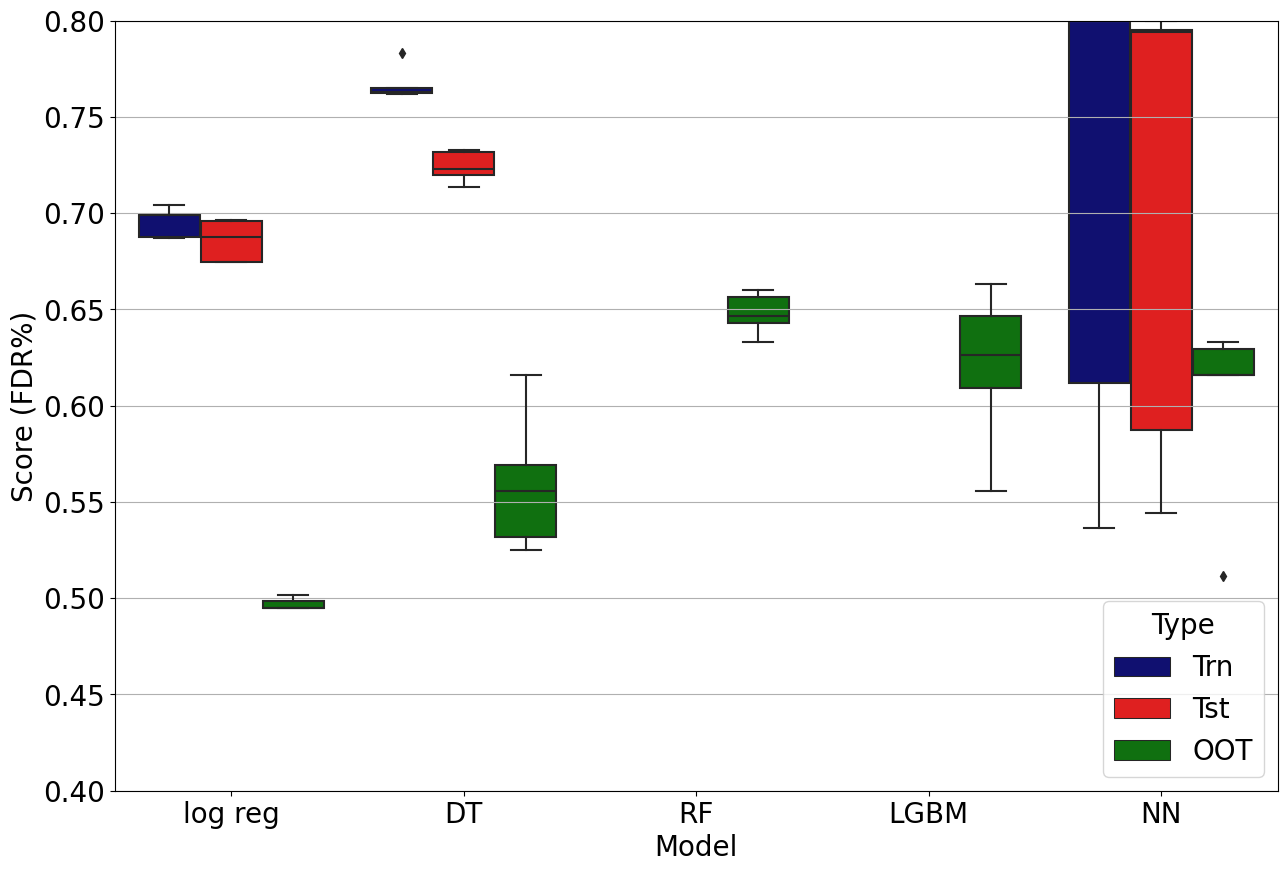

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,.8)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

This next cell can be used to explore overfitting

0 0.8149078726968174 0.7715827338129496 0.6161616161616161
1 0.049019607843137254 0.04752851711026616 0.05723905723905724
2 0.8214578214578214 0.8128544423440454 0.6127946127946128
loop trn tst oot 1 0.42134632549944406 0.40799142331681526 0.32154882154882153
0 0.8312858312858313 0.7693761814744802 0.6094276094276094
1 0.5647540983606557 0.5358490566037736 0.6296296296296297
2 0.8291900561347233 0.8250497017892644 0.6363636363636364
loop trn tst oot 2 0.5563074964453025 0.5325687349668795 0.46885521885521886
0 0.8289689034369886 0.8068181818181818 0.6632996632996633
1 0.03293172690763052 0.027722772277227723 0.06397306397306397
2 0.8197115384615384 0.8047808764940239 0.6262626262626263
loop trn tst oot 3 0.42040304220153935 0.40983045764735837 0.3383838383838384
0 0.8387358184764991 0.7868217054263565 0.6060606060606061
1 0.5348460291734197 0.5445736434108527 0.622895622895623
2 0.8291873963515755 0.7849264705882353 0.5993265993265994
loop trn tst oot 4 0.5506923110003736 0.52908045485

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


2 0.03025347506132461 0.028462998102466792 0.06397306397306397
loop trn tst oot 6 0.38761192689983315 0.3682418630137278 0.2962962962962963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0 0.728251864125932 0.7440147329650092 0.6094276094276094


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


1 0.7445193929173693 0.725177304964539 0.6026936026936027


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


2 0.022651006711409395 0.021505376344086023 0.0707070707070707
loop trn tst oot 7 0.3738555659386777 0.37267435356840856 0.3207070707070707


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0 0.6702302631578947 0.6872659176029963 0.494949494949495
1 0.17158818834796488 0.18108651911468812 0.1447811447811448


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


2 0.37428337428337427 0.34782608695652173 0.3400673400673401
loop trn tst oot 8 0.30402545644730844 0.3040446309185515 0.24494949494949494
0 0.5520399666944213 0.5628415300546448 0.6094276094276094
1 0.8330592105263158 0.797752808988764 0.6094276094276094
2 0.563953488372093 0.5384615384615384 0.6262626262626263
loop trn tst oot 9 0.48726316639820755 0.47476396937623677 0.4612794612794613


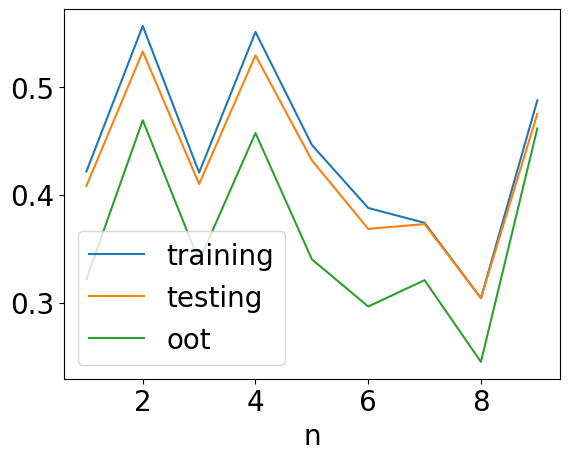

CPU times: user 1h 15min 16s, sys: 3min 26s, total: 1h 18min 42s
Wall time: 10min 23s


In [199]:
# %%time
# nitermax2 = 3
# training = []
# testing = []
# oot = []
# results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
# for i in range(1,10):
#     for niter in range(nitermax2):
#         X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
#         model = MLPClassifier(
#     hidden_layer_sizes=(100, 1),  
#     activation='relu',             # Rectified Linear Unit activation function
#     alpha = 0.0001/i,                  # L2 penalty (regularization term)
#     learning_rate_init = 0.0001,      # Initial learning rate for weight updates
#     max_iter = 500,                 # Maximum number of iterations
#     learning_rate='constant'       # Learning rate schedule
# )

#         model.fit(X_trn, Y_trn.values.ravel()) 

#         X_oot = X_oot_orig.copy()
#         X_trn_save = X_trn.copy()
#         Y_trn_save = Y_trn.copy()
    
#         predictions = model.predict_proba(X_trn_save)[:,1]
#         X_trn['predicted'] = predictions
#         X_trn['Fraud'] = Y_trn_save['Fraud']
#         topRows = int(round(X_trn.shape[0]*detect_rate))
#         temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#         predictions = model.predict_proba(X_tst)[:,1]
#         X_tst['predicted']=predictions
#         X_tst['Fraud'] = Y_tst['Fraud']
#         topRows = int(round(X_tst.shape[0]*detect_rate))
#         temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#         predictions = model.predict_proba(X_oot)[:,1]
#         X_oot['predicted']=predictions
#         X_oot['Fraud'] = Y_oot['Fraud']
#         topRows = int(round(X_oot.shape[0]*detect_rate))
#         temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#         print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

#     results_mean_trn = results['trn'].mean()
#     results_mean_tst = results['tst'].mean()
#     results_mean_oot = results['oot'].mean()
#     print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
#     training.append(results_mean_trn)
#     testing.append(results_mean_tst)
#     oot.append(results_mean_oot)

# table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True) 
# table.plot()
# plt.savefig('complexity_NN.pdf', format='pdf')
# plt.show()

In [219]:
best_OOT

0.6632996632996633

The rest of the notebook makes the tables for the final model of choice. 

In [221]:
%%time
# need to set this next value to around the highest oot fdr for model of choice.
# The model then runs a nombermof times with the fixed hyperparameters until it finds a good model.
desire = .62
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# put your final model of choice
# run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# look at all these runs and select a value of the oot performance where we want to break out this loop
# that will be final model run of choice

    model = lgb.LGBMClassifier(
    num_leaves = 100,
    max_depth = 10, 
    learning_rate = 0.05,     # learning rate
    n_estimators = 50       # Number of boosting rounds
)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.62
[LightGBM] [Info] Number of positive: 1218, number of negative: 58466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3692
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020407 -> initscore=-3.871235
[LightGBM] [Info] Start training from score -3.871235
0 0.9770114942528736 0.900375939849624 0.6060606060606061
[LightGBM] [Info] Number of positive: 1220, number of negative: 58464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3696
[LightGBM] [Info] Number of data points i

In [222]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [223]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,...,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since,predicted,Fraud
90077,-0.465180,10.277730,-0.088420,-0.268718,-0.320825,5.356783,0.923778,1.892914,1.493632,8.156177,...,2.598968,1.638749,-0.320865,-0.806676,-0.724433,-0.73743,-0.153810,-0.361615,0.931961,1
90076,-0.465180,10.073284,-0.368430,-0.490890,-0.320825,5.245520,0.923778,-0.732159,1.493632,7.992005,...,2.548852,-0.778803,-0.320865,-0.806676,-0.724433,-0.73743,-0.148679,-0.159898,0.931912,1
96324,7.256559,-0.323101,-0.466823,-0.522920,-0.320825,-0.182975,0.923778,-0.753291,-0.188352,-0.356402,...,0.106969,-0.798264,-0.320865,5.211513,4.464614,4.24877,-0.148679,0.398705,0.919251,1
90868,5.969603,-0.292024,-0.466799,1.719141,5.976505,0.216628,0.923778,1.892914,-0.185289,-0.331447,...,0.176714,1.638749,5.976444,3.205450,2.907900,2.75291,-0.153810,-0.361615,0.912061,1
90874,5.969603,-0.283842,-0.466799,1.817364,6.548989,-0.171819,0.923778,1.892914,-0.185289,-0.324877,...,0.189180,1.638749,6.548927,3.205450,3.167352,3.00222,-0.153810,-0.361615,0.911199,1
96249,8.543516,-0.270776,-0.466822,2.069939,5.976505,-0.383902,0.923778,1.892914,-0.188352,-0.314385,...,0.102692,1.638749,5.976444,4.810300,3.945709,3.75015,-0.153810,-0.361615,0.910346,1
96225,7.256559,0.130159,-0.466822,1.848382,4.831536,0.738526,0.923778,1.892914,-0.188352,0.007570,...,0.084136,1.638749,4.831479,4.007875,3.426804,3.25153,-0.153810,-0.361615,0.909527,1
90865,5.969603,0.132840,-0.466799,1.612376,5.404020,0.480096,0.923778,1.892914,-0.185289,0.009723,...,0.166252,1.638749,5.403962,3.205450,2.648447,2.50360,-0.153810,-0.361615,0.909527,1
94031,7.900037,-0.324642,-0.466813,0.764189,5.404020,-0.413217,0.923778,1.671754,-0.114619,-0.357639,...,0.219679,1.638749,5.403962,4.409088,3.686257,3.75015,-0.153810,-0.361615,0.908140,1
96243,7.900037,-0.322929,-0.466822,1.964700,5.404020,-0.412285,0.923778,1.892914,-0.188352,-0.356264,...,0.087022,1.638749,5.403962,4.409088,3.686257,3.50084,-0.153810,-0.361615,0.908140,1


In [224]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,21.0,101.0,17.213115,82.786885,122.0,21.0,101.0,0.175953,34.006734,33.830781,0.207921
2,2.0,123.0,58.0,65.0,47.154472,52.845528,245.0,79.0,166.0,0.661919,55.892256,55.230337,0.475904
3,3.0,122.0,96.0,26.0,78.688525,21.311475,367.0,175.0,192.0,1.466276,64.646465,63.180189,0.911458
4,4.0,122.0,102.0,20.0,83.606557,16.393443,489.0,277.0,212.0,2.320905,71.380471,69.059566,1.306604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11447.0,296.0,95.911186,99.663300,3.752114,38.672297
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11569.0,296.0,96.933389,99.663300,2.729910,39.084459
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11691.0,296.0,97.955593,99.663300,1.707707,39.496622
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11814.0,296.0,98.986175,99.663300,0.677125,39.912162


Max possible savings: 51,252,000.0


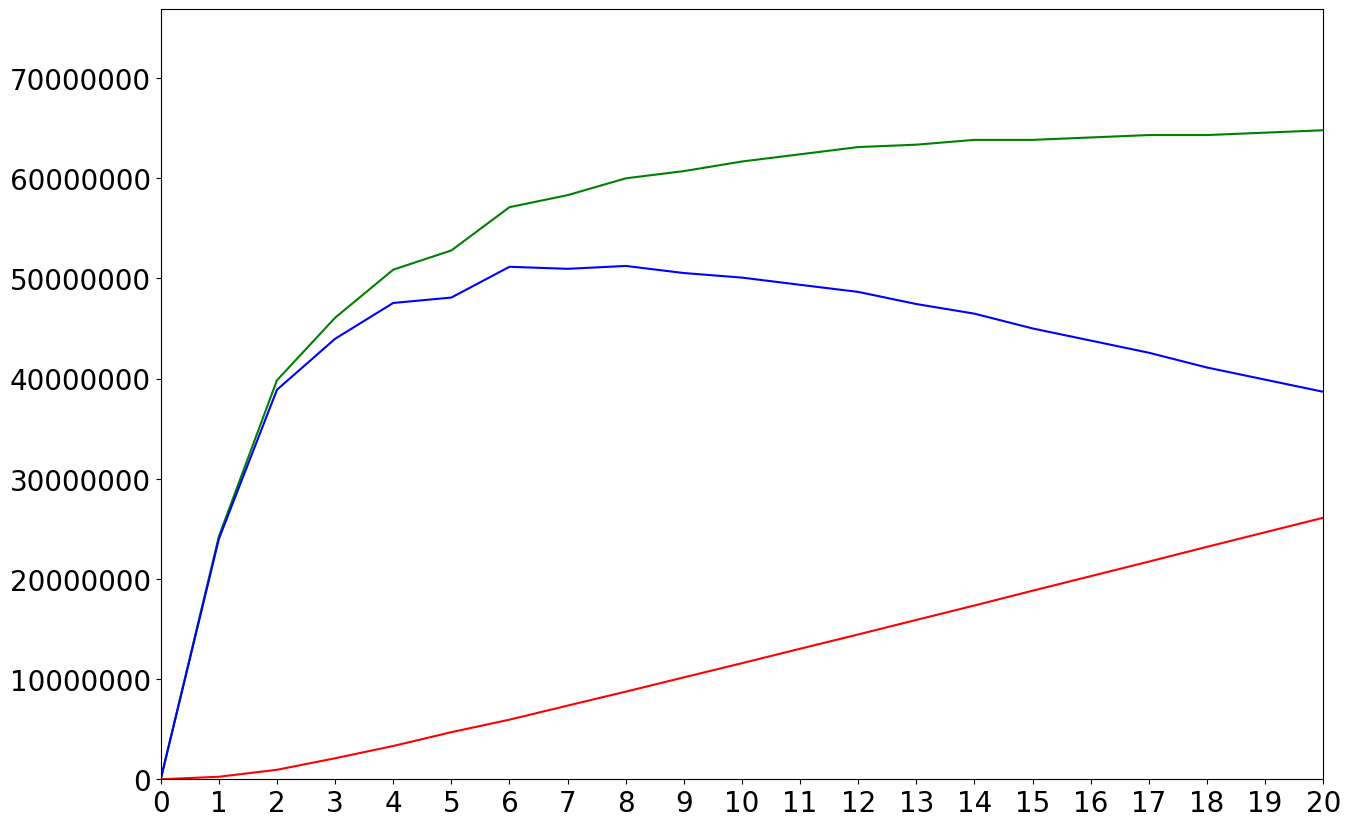

In [227]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green', label='Fraud Savings')
plt.plot(Financials_oot['FP Loss'], color='red', label='FP Loss')
plt.plot(Financials_oot['Overall Savings'], color='blue', label='Overall Savings')

xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [206]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,18.0,104.0,14.754098,85.245902,122.0,18.0,104.0,0.150817,35.016835,34.866018,0.173077
2,2.0,123.0,64.0,59.0,52.032520,47.967480,245.0,82.0,163.0,0.687055,54.882155,54.195100,0.503067
3,3.0,122.0,95.0,27.0,77.868852,22.131148,367.0,177.0,190.0,1.483033,63.973064,62.490031,0.931579
4,4.0,122.0,108.0,14.0,88.524590,11.475410,489.0,285.0,204.0,2.387935,68.686869,66.298934,1.397059
5,5.0,123.0,114.0,9.0,92.682927,7.317073,612.0,399.0,213.0,3.343109,71.717172,68.374063,1.873239
6,6.0,122.0,110.0,12.0,90.163934,9.836066,734.0,509.0,225.0,4.264767,75.757576,71.492808,2.262222
7,7.0,122.0,114.0,8.0,93.442623,6.557377,856.0,623.0,233.0,5.219941,78.451178,73.231237,2.673820
8,8.0,123.0,119.0,4.0,96.747967,3.252033,979.0,742.0,237.0,6.217009,79.797980,73.580971,3.130802
9,9.0,122.0,114.0,8.0,93.442623,6.557377,1101.0,856.0,245.0,7.172183,82.491582,75.319400,3.493878


In [207]:
FDR.to_csv('FDR.csv')

In [208]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [209]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [210]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

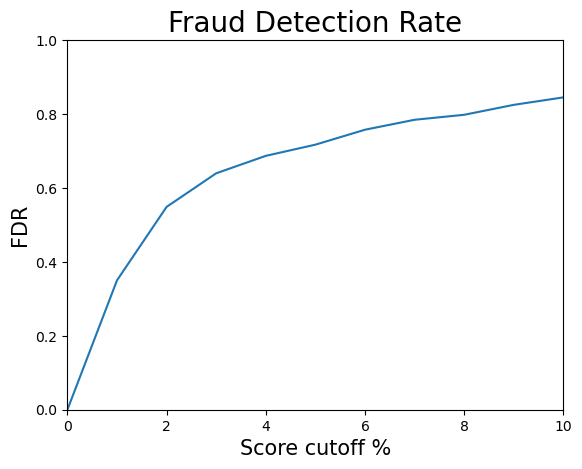

In [211]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

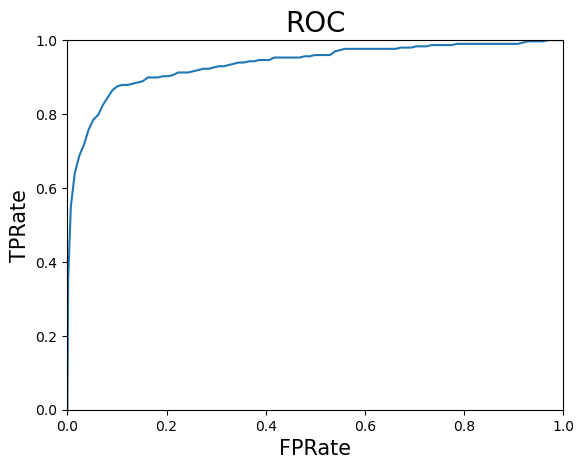

In [212]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [215]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 278 ms, sys: 14.1 ms, total: 293 ms
Wall time: 103 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(97496, 10)

In [216]:
df['prediction'] = model.predict_proba(X)[:,1]

In [217]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [218]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.002315
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.002315
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.002209
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.002315
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.002595


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [125]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
47663,47664,5142181728,2010-06-22,999960264339,FCN/CRC/LEWIS/SLP,DC,33431.0,P,2374.45,1,1.000000
36143,36144,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,627.17,1,0.997536
14065,14066,5142847398,2010-02-27,4503738417400,DIRKS PLUMBING/HEATING REPAIRS,TN,38118.0,P,875.74,1,0.997015
48148,48149,5142181728,2010-06-23,6000350792548,TIME OFFICE PRODUCTS,DC,20006.0,P,1317.16,1,0.996524
18566,18567,5142847398,2010-03-14,4503738417400,DIRKS PLUMBING/HEATING REPAIRS,TN,38118.0,P,595.59,1,0.996004
15586,15587,5142847398,2010-03-03,4503738417400,DIRKS PLUMBING/HEATING REPAIRS,TN,38118.0,P,261.20,1,0.992063
15184,15185,5142847398,2010-03-02,4503738417400,DIRKS PLUMBING/HEATING REPAIRS,TN,38118.0,P,314.50,1,0.991956
48282,48283,5142181728,2010-06-24,4000356664805,HISPANIC MANAGEMENT,DC,NaN,P,32.19,1,0.990227
63514,63515,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,838.50,1,0.988111
63520,63521,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,809.83,1,0.988111


In [126]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [127]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [128]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

116

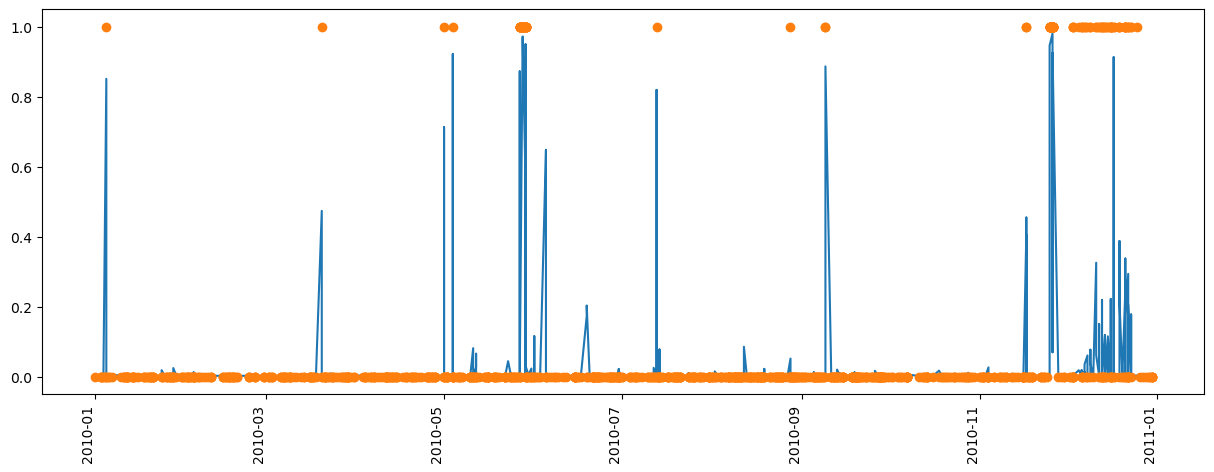

In [129]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [130]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.002357
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.002345
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.002328
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.002399
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.002809


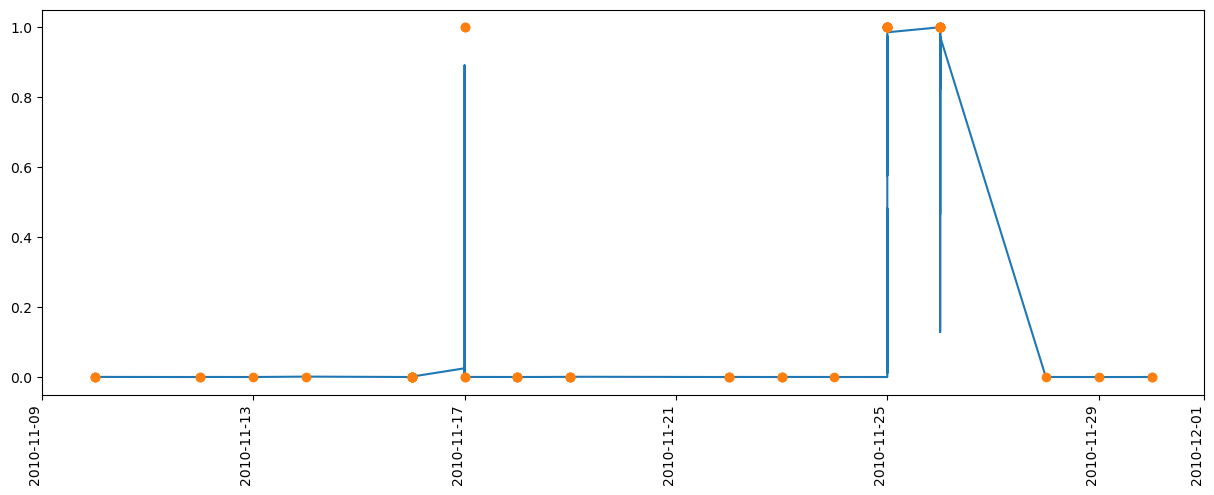

In [76]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

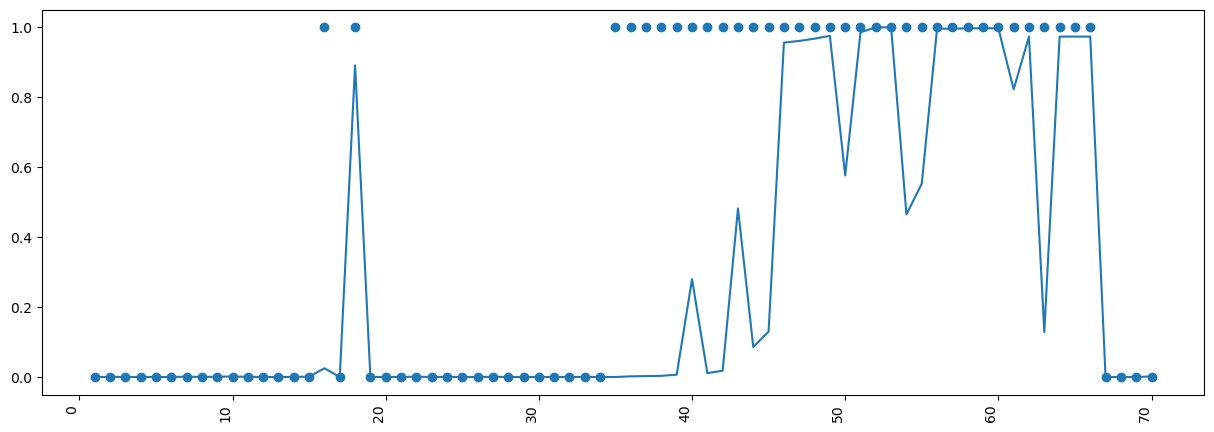

In [77]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [78]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.000098
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.000419
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.000358
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000017
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000247
5,6,87948,87949,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.000055
6,7,87964,87965,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.001176
7,8,88251,88252,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.000055
8,9,88287,88288,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.001038
9,10,88393,88394,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.001526


# Score Calibration

In [79]:
base = 700
delta = 40
odds_at_base = 1

In [80]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 22)

In [81]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_total_7,card_merch_vdratio_0by14,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_1,state_des_total_3,card_zip_count_1_by_60_sq,Card_dow_vdratio_0by14,Cardnum_max_14,Card_Merchdesc_total_30,...,Cardnum_total_14,Card_dow_vdratio_0by7,Card_dow_unique_count_for_state_des_1,Cardnum_unique_count_for_card_state_7,Cardnum_unique_count_for_card_zip_7,Cardnum_unique_count_for_Merchnum_7,Cardnum_day_since,Card_dow_day_since,predicted,Fraud
50634,-0.465180,-0.329586,-0.466615,-0.289978,-0.320825,-0.415908,0.923778,-0.719539,-0.264029,-0.361609,...,-0.375470,-0.767180,-0.320865,-0.806676,-0.724433,-0.73743,-0.092244,-0.221964,0.000017,0
68415,-0.465180,-0.308183,-0.466687,0.900611,-0.320825,-0.404260,0.923778,-0.672542,0.029797,-0.344423,...,-0.323584,-0.642428,-0.320865,-0.806676,-0.724433,-0.73743,-0.081983,-0.330582,0.000065,0
33410,-0.465180,-0.328457,-0.466531,4.174731,0.251660,-0.415293,0.923778,1.892914,-0.711221,-0.360703,...,-0.487525,1.638749,0.251618,-0.806676,-0.724433,-0.48812,-0.153810,-0.361615,0.000630,0
76814,0.821777,-0.206819,-0.304551,-0.034852,0.824144,1.160221,-0.895497,1.229434,0.563787,-0.234514,...,0.785963,1.638749,0.824100,-0.004251,-0.205528,-0.23881,-0.153810,-0.361615,0.002700,0
77196,-0.465180,1.819510,0.133475,-0.463606,-0.320825,1.269661,-1.517880,0.300562,0.509985,2.072286,...,1.041837,0.172278,-0.320865,-0.405464,-0.205528,-0.23881,-0.153810,-0.361615,0.099020,0


In [82]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
13067,0.00001,0
20415,0.00001,0
51864,0.00001,0
44268,0.00001,0
38543,0.00001,0


In [83]:
calib.shape

(97496, 2)

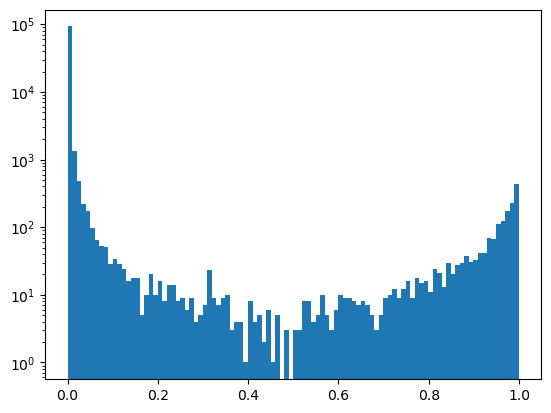

In [84]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [85]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [86]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [87]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000010,0.000000,0.000001,-13.790193,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000010,0.000000,0.000001,-13.790193,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000010,0.000000,0.000001,-13.790193,-8.000000
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3900.0,0.0,0.000010,0.000000,0.000001,-13.790193,-8.000000
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4875.0,0.0,0.000010,0.000000,0.000001,-13.790193,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,955.0,20.0,97.948718,2.051282,93600.0,93483.0,113.0,0.011593,2.051282,0.020943,-3.865929,-3.865929
97,97.0,975.0,930.0,45.0,95.384615,4.615385,94575.0,94413.0,158.0,0.020426,4.615385,0.048388,-3.028500,-3.028500
98,98.0,975.0,886.0,89.0,90.871795,9.128205,95550.0,95299.0,247.0,0.083345,9.128205,0.100453,-2.298069,-2.298069
99,99.0,975.0,131.0,844.0,13.435897,86.564103,96525.0,95430.0,1091.0,0.776238,86.564103,6.442756,1.862956,1.862956


In [88]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,955.0,20.0,97.948718,2.051282,93600.0,93483.0,113.0,0.011593,2.051282,0.020943,-3.865929,-3.865929
97,97.0,975.0,930.0,45.0,95.384615,4.615385,94575.0,94413.0,158.0,0.020426,4.615385,0.048388,-3.028500,-3.028500
98,98.0,975.0,886.0,89.0,90.871795,9.128205,95550.0,95299.0,247.0,0.083345,9.128205,0.100453,-2.298069,-2.298069
99,99.0,975.0,131.0,844.0,13.435897,86.564103,96525.0,95430.0,1091.0,0.776238,86.564103,6.442756,1.862956,1.862956
100,100.0,975.0,19.0,956.0,1.948718,98.051282,97500.0,95449.0,2047.0,0.984567,98.051282,50.315842,3.918320,3.918320


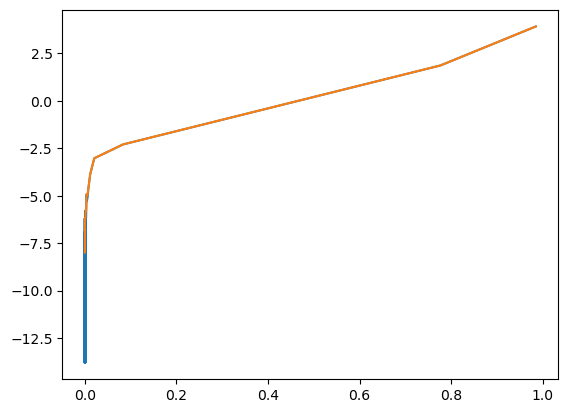

In [89]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [90]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [91]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.95568396  0.96521058 -0.00250908]


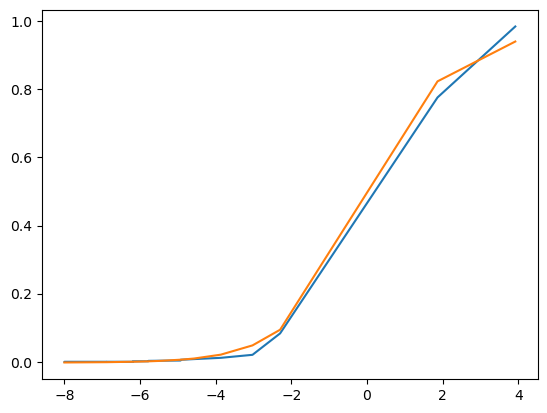

In [92]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


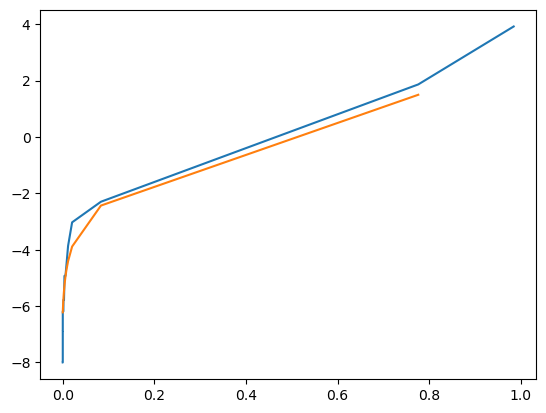

In [93]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [94]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.0,0.0,975.0,975.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
2,2.0,975.0,975.0,0.0,100.0,0.0,1950.0,1950.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
3,3.0,975.0,975.0,0.0,100.0,0.0,2925.0,2925.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
4,4.0,975.0,975.0,0.0,100.0,0.0,3900.0,3900.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
5,5.0,975.0,975.0,0.0,100.0,0.0,4875.0,4875.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
6,6.0,975.0,975.0,0.0,100.0,0.0,5850.0,5850.0,0.0,0.000010,0.0,0.000001,-13.790193,-8.0,-6.221553
7,7.0,975.0,975.0,0.0,100.0,0.0,6825.0,6825.0,0.0,0.000011,0.0,0.000001,-13.790193,-8.0,-6.221228
8,8.0,975.0,975.0,0.0,100.0,0.0,7800.0,7800.0,0.0,0.000012,0.0,0.000001,-13.790193,-8.0,-6.220522
9,9.0,975.0,975.0,0.0,100.0,0.0,8775.0,8775.0,0.0,0.000014,0.0,0.000001,-13.790193,-8.0,-6.219759
10,10.0,975.0,975.0,0.0,100.0,0.0,9750.0,9750.0,0.0,0.000016,0.0,0.000001,-13.790193,-8.0,-6.218955


In [95]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [96]:
calib.head()

,score_raw,Fraud
13067,0.00001,0
20415,0.00001,0
51864,0.00001,0
44268,0.00001,0
38543,0.00001,0


In [97]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,score_raw,Fraud,score_calib
13067,0.00001,0,451.137871
20415,0.00001,0,451.137871
51864,0.00001,0,451.137871
44268,0.00001,0,451.137871
38543,0.00001,0,451.137871


In [98]:
calib.tail()

,score_raw,Fraud,score_calib
20258,0.999,1,999.0
42450,0.999,1,999.0
42437,0.999,1,999.0
63187,0.999,1,999.0
63489,0.999,1,999.0


In [99]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019371,0.020996,470.147003
std,0.125854,0.143371,65.707157
min,0.000010,0.000000,451.137871
25%,0.000060,0.000000,451.963647
50%,0.000218,0.000000,454.464091
75%,0.000754,0.000000,462.003556
max,0.999000,1.000000,999.000000


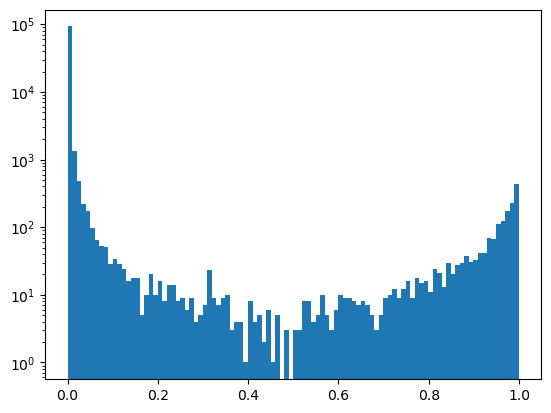

In [100]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

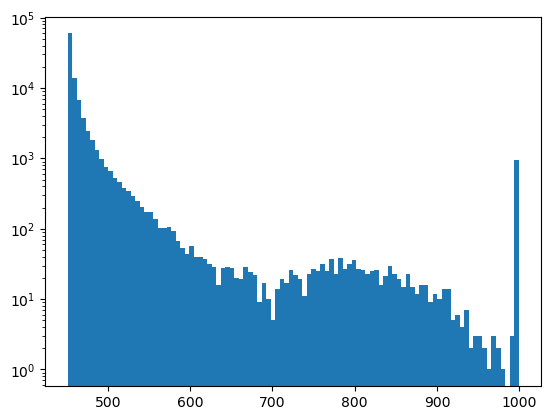

In [101]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

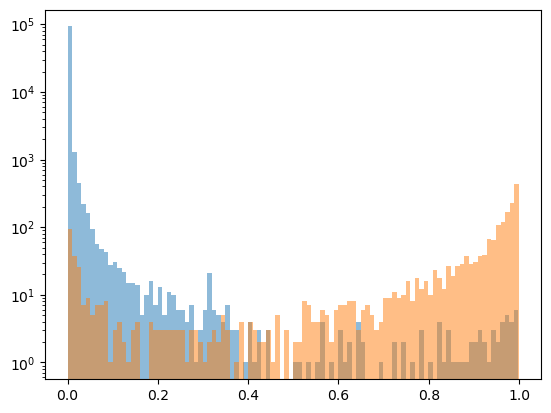

In [102]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

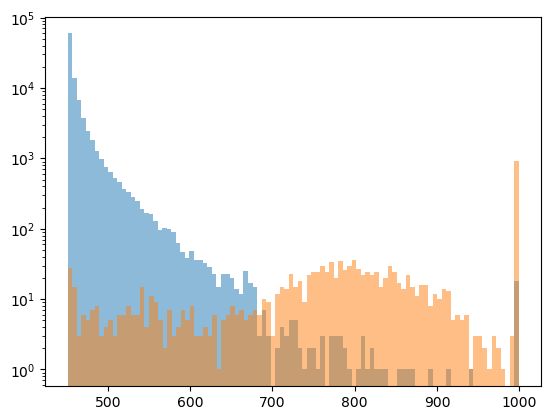

In [103]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')